# Athens Short-term rentals price prediction

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split,RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import time
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Load Data

In [2]:
df = pd.read_csv('athens_listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,27262,https://www.airbnb.com/rooms/27262,20250318145108,2025-03-20,previous scrape,"AQA-No7, Great mattress, high speed internet",THE MATTRESS - KING KOIL - Camden Luxury 160x2...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,37177,https://www.airbnb.com/users/show/37177,Emmanouil,2009-09-08,"Athens, Greece",Athens Quality Apartments is a company started...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/859c1...,https://a0.muscache.com/im/pictures/user/859c1...,NaN,4,12,"['email', 'phone']",t,t,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,NaN,37.98924,23.76500,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,NaN,"[""Hot water"", ""Hangers"", ""Refrigerator"", ""Cent...",NaN,1,1125,1.0,3.0,1125.0,1125.0,2.2,1125.0,NaN,t,0,0,0,0,2025-03-20,29,4,0,0,5,24,NaN,2012-09-21,2024-11-18,4.86,4.89,4.90,4.86,4.97,4.75,4.71,00002433111,t,1,1,0,0,0.19
1,33945,https://www.airbnb.com/rooms/33945,20250318145108,2025-03-19,city scrape,Spacious Cosy aprtm very close to Metro!,Apartment located near metro station. Safe nei...,Neighbourhood is alive all day and safe all da...,https://a0.muscache.com/pictures/1a7a1026-f5f1...,146553,https://www.airbnb.com/users/show/146553,Katerina,2010-06-17,Greece,"Kind, respectful, generous and giving\r\n",within a few hours,100%,71%,f,https://a0.muscache.com/im/pictures/user/4cfe0...,https://a0.muscache.com/im/pictures/user/4cfe0...,Agios Nikolaos,2,2,"['email', 'phone']",t,t,"Athens, Αττική, Greece",ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ,NaN,38.00673,23.72775,Entire condo,Entire home/apt,4,1.0,1 bath,2.0,3.0,"[""Long term stays allowed"", ""Hot water"", ""Elev...",$30.00,4,1125,4.0,4.0,1125.0,1125.0,4.0,1125.0,NaN,t,16,20,21,274,2025-03-19,79,10,1,197,8,80,2400.0,2010-11-02,2025-03-10,4.73,4.74,4.69,4.88,4.89,4.62,4.80,00000874421,f,2,2,0,0,0.45
2,49489,https://www.airbnb.com/rooms/49489,20250318145108,2025-03-19,city scrape,Ermou 44 - 3bdr apt in the heart of Athens,"Fully furnished, 98 sq.mt., apartment on 44 Er...",The apartment is located at the commercial cen...,https://a0.muscache.com/pictures/9640239/4bfd2...,225612,https://www.airbnb.com/users/show/225612,Stathis,2010-09-06,"Athens, Greece",Hi everyone! My name is Stathis and I own Athe...,within an hour,100%,75%,f,https://a0.muscache.com/im/users/225612/profil...,https://a0.muscache.com/im/users/225612/profil...,NaN,1,2,"['email', 'phone', 'work_email']",t,t,"Athens, Αττική, Greece",ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ,NaN,37.97670,23.73064,Entire rental unit,Entire home/apt,7,1.5,1.5 baths,3.0,4.0,"[""Hot water"", ""Elevator"", ""Hangers"", ""Heating""...",$160.00,2,365,2.0,2.0,1125.0,1125.0,2.0,1

## Data Preprocessing

### Check null values

In [3]:
df.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
name                                                0
description                                       336
neighborhood_overview                            7447
picture_url                                         0
host_id                                             0
host_url                                            0
host_name                                           0
host_since                                          0
host_location                                    4792
host_about                                       7546
host_response_time                               1986
host_response_rate                               1986
host_acceptance_rate                              848
host_is_superhost           

### Drop columns that are not usefull for prediction

In [4]:
df = df.drop(columns=['license', 'calendar_updated', 'neighbourhood','neighbourhood_group_cleansed',
                      'neighborhood_overview', 'description','name','id','listing_url','scrape_id','source','last_scraped','picture_url',
                      'host_id','host_url','host_name','host_location','host_about','host_response_time','host_acceptance_rate',
                      'host_thumbnail_url','host_picture_url','host_neighbourhood','host_verifications','host_has_profile_pic',
                      'host_response_rate','amenities','has_availability','calendar_last_scraped','first_review', 'last_review', 'instant_bookable',
                      'estimated_occupancy_l365d','estimated_revenue_l365d','neighbourhood_cleansed','room_type'])

### Clean Price column

In [5]:
print(df['price'].head(10))

0        NaN
1     $30.00
2    $160.00
3     $50.00
4     $37.00
5     $70.00
6     $56.00
7     $50.00
8        NaN
9     $50.00
Name: price, dtype: object


In [6]:
# Remove currency symbols and convert to float
df['price'] = df['price'].str.replace('[$,]', '', regex=True).astype(float)

# Remove outliers
df = df[df['price'].between(*df['price'].quantile([0.05, 0.995])) & (df['price'] > 0)]

print(df['price'].describe())

print(f"Final dataset shape: {df.shape}")


count    13165.000000
mean        89.942803
std         88.203253
min         28.000000
25%         46.000000
50%         63.000000
75%         95.000000
max        655.000000
Name: price, dtype: float64
Final dataset shape: (13165, 43)


### Clean similar propery types

In [7]:
# Clean property_type column 
print("Original property_type distribution:")
print(df['property_type'].value_counts())

# Fix propery types
df['property_type'] = df['property_type'].replace({
    'Entire home/apt': 'Entire rental unit',
    'Entire serviced apartment': 'Entire rental unit',
    'Room in aparthotel': 'Room in hotel',
    'Room in boutique hotel': 'Room in hotel',
    'Private room in condo': 'Private room in rental unit',
    'Private room in home': 'Private room in rental unit',
    'Private room in serviced apartment': 'Private room in rental unit',
    'Room in serviced apartment': 'Private room in rental unit',
    'Entire townhouse': 'Entire rental unit',
    'Entire villa': 'Entire rental unit',
    'Private room in guest suite': 'Private room in rental unit',
    'Private room in bed and breakfast': 'Private room in hotel',
    'Private room in hostel': 'Private room in hotel',
    'Entire vacation home': 'Entire rental unit',
    'Tiny home': 'Entire rental unit',  
})

# Replace categories with less than 13 listings
small_categories = df['property_type'].value_counts()[df['property_type'].value_counts() < 10].index
df.loc[df['property_type'].isin(small_categories), 'property_type'] = 'Entire rental unit'

# Final proprty type
print("\nFinal property_type distribution:")
print(df['property_type'].value_counts())

Original property_type distribution:
property_type
Entire rental unit                    8838
Entire condo                          2719
Entire home                            350
Entire serviced apartment              252
Private room in rental unit            236
Room in hotel                          171
Room in aparthotel                     117
Entire loft                            116
Room in boutique hotel                  67
Private room in condo                   51
Private room in home                    28
Entire townhouse                        26
Room in serviced apartment              24
Private room in serviced apartment      22
Private room in guest suite             18
Private room in bed and breakfast       16
Entire villa                            16
Private room in hostel                  14
Entire vacation home                    12
Tiny home                               11
Entire place                             9
Entire guest suite                       9
Ent

### Feature Engineering

In [8]:
# Calculate distance to Acropolis using Manhattan distance formula
df['distance_acropolis'] = (np.abs(df['latitude'] - 37.9715) + 
                           np.abs(df['longitude'] - 23.7267) * np.cos(np.radians(37.9715))) * 111.32
df.drop(columns=['latitude','longitude'], inplace=True)

# Bathrooms
df['bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
df['bathrooms'] = df['bathrooms'].fillna(1).apply(lambda x: max(1, round(float(x))))
df.drop(columns=['bathrooms_text'], inplace=True)


#Rooms
df['rooms'] = df['bedrooms'] + df['bathrooms']

df.drop(columns=['bedrooms','bathrooms'], inplace=True)


# Convert host_since to datetime and calculate experience
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

df['host_experience_years'] = (pd.Timestamp.now() - df['host_since']).dt.days / 365.25
df['host_experience_years'] = df['host_experience_years'].fillna(0)

df.drop(columns=['host_since'], inplace=True)

df['host_is_superhost'] = (df['host_is_superhost'] == 't').astype(int)

#Host verified
df['host_verified'] = (df['host_identity_verified'] == 't').astype(int)
df.drop(columns=['host_identity_verified'], inplace=True)

# Review scores rating
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())

# Availability ratio and low availability indicator
df['availability_ratio'] = df['availability_365'] / 365

In [9]:
df

,host_is_superhost,host_listings_count,host_total_listings_count,property_type,accommodates,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance_acropolis,rooms,host_experience_years,host_verified,availability_ratio
1,0,2,2,Entire condo,4,3.0,30.0,4,1125,4.0,4.0,1125.0,1125.0,4.0,1125.0,16,20,21,274,79,10,1,197,8,4.73,4.74,4.69,4.88,4.89,4.62,4.80,2,2,0,0,0.45,4.013947,3.0,15.115674,1,0.750685
2,0,1,2,Entire rental unit,7,4.0,160.0,2,365,2.0,2.0,1125.0,1125.0,2.0,1125.0,8,17,31,172,140,4,0,172,4,4.68,4.78,4.69,4.84,4.86,4.88,4.70,1,1,0,0,0.85,0.924620,5.0,14.893908,1,0.471233
3,1,1,2,Entire condo,2,3.0,50.0,6,210,6.0,6.0,210.0,210.0,6.0,210.0,11,11,11,86,35,5,0,86,5,4.97,4.97,4.94,4.91,4.97,4.91,4.94,1,1,0,0,0.29,1.659133,2.0,14.694045,1,0.235616
4,0,1,4,Entire condo,2,1.0,37.0,3,90,3.0,3.0,90.0,90.0,3.0,90.0,30,60,90,288,56,4,0,288,4,4.65,4.63,4.36,4.96,4.93,4.52,4.83,1,1,0,0,0.34,2.845954,2.0,14.154689,1,0.789041
5,0,3,3,Entire rental unit,4,2.0,70.0,2,366,2.0,2.0,366.0,366.0,2.0,366.0,12,18,33,304,215,18,0,227,18,4.72,4.80,4.68,4.85,4.89,4.58,4.66,1,1,0,0,1.29,2.158240,2.0,14.094456,1,0.832877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14982,0,8,8,Entire rental unit,2,1.0,75.0,2,90,2.0,2.0,90.0,90.0,2.0,90.0,30,60,90,365,0,0,0,288,0,4.88,NaN,NaN,NaN,NaN,NaN,NaN,8,8,0,0,NaN,0.895201,2.0,0.605065,1,1.000000
14983,0,8,8,Entire rental unit,2,1.0,60.0,2,90,2.0,2.0,90.0,90.0,2.0,90.0,30,60,90,365,0,0,0,288,0,4.88,NaN,NaN,NaN,NaN,NaN,NaN,8,8,0,0,NaN,0.854709,2.0,0.605065,1,1.000000
14984,0,11,11,Entire rental unit,9,3.0,180.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,30,60,90,360,0,0,0,283,0,4.88,NaN,NaN,NaN,NaN,NaN,NaN,7,7,0,0,NaN,1.109974,4.0,7.049966,1,0.986301
14985,0,196,209,Entire rental unit,2,1.0,39.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,15,40,70,343,1,1,1,266,0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,34,34,0,0,1.00,1.852627,2.0,3.455168,1,0.939726


### Remove Room Outliers

In [10]:
### Fix Outliers in Rooms Column

print("Before cleaning:")
print(df['rooms'].value_counts().sort_index())

# Replace rooms > 10 with 2
df.loc[df['rooms'] > 10, 'rooms'] = 2

print("\nAfter cleaning:")
print(df['rooms'].value_counts().sort_index())

Before cleaning:
rooms
1.0      682
2.0     7471
3.0     2751
4.0     1379
5.0      537
6.0      165
7.0       62
8.0       59
9.0       29
10.0      15
11.0       1
12.0       2
14.0       3
16.0       1
17.0       1
18.0       1
22.0       1
Name: count, dtype: int64

After cleaning:
rooms
1.0      682
2.0     7481
3.0     2751
4.0     1379
5.0      537
6.0      165
7.0       62
8.0       59
9.0       29
10.0      15
Name: count, dtype: int64


## Feature Selection

### Check for multicolinearity

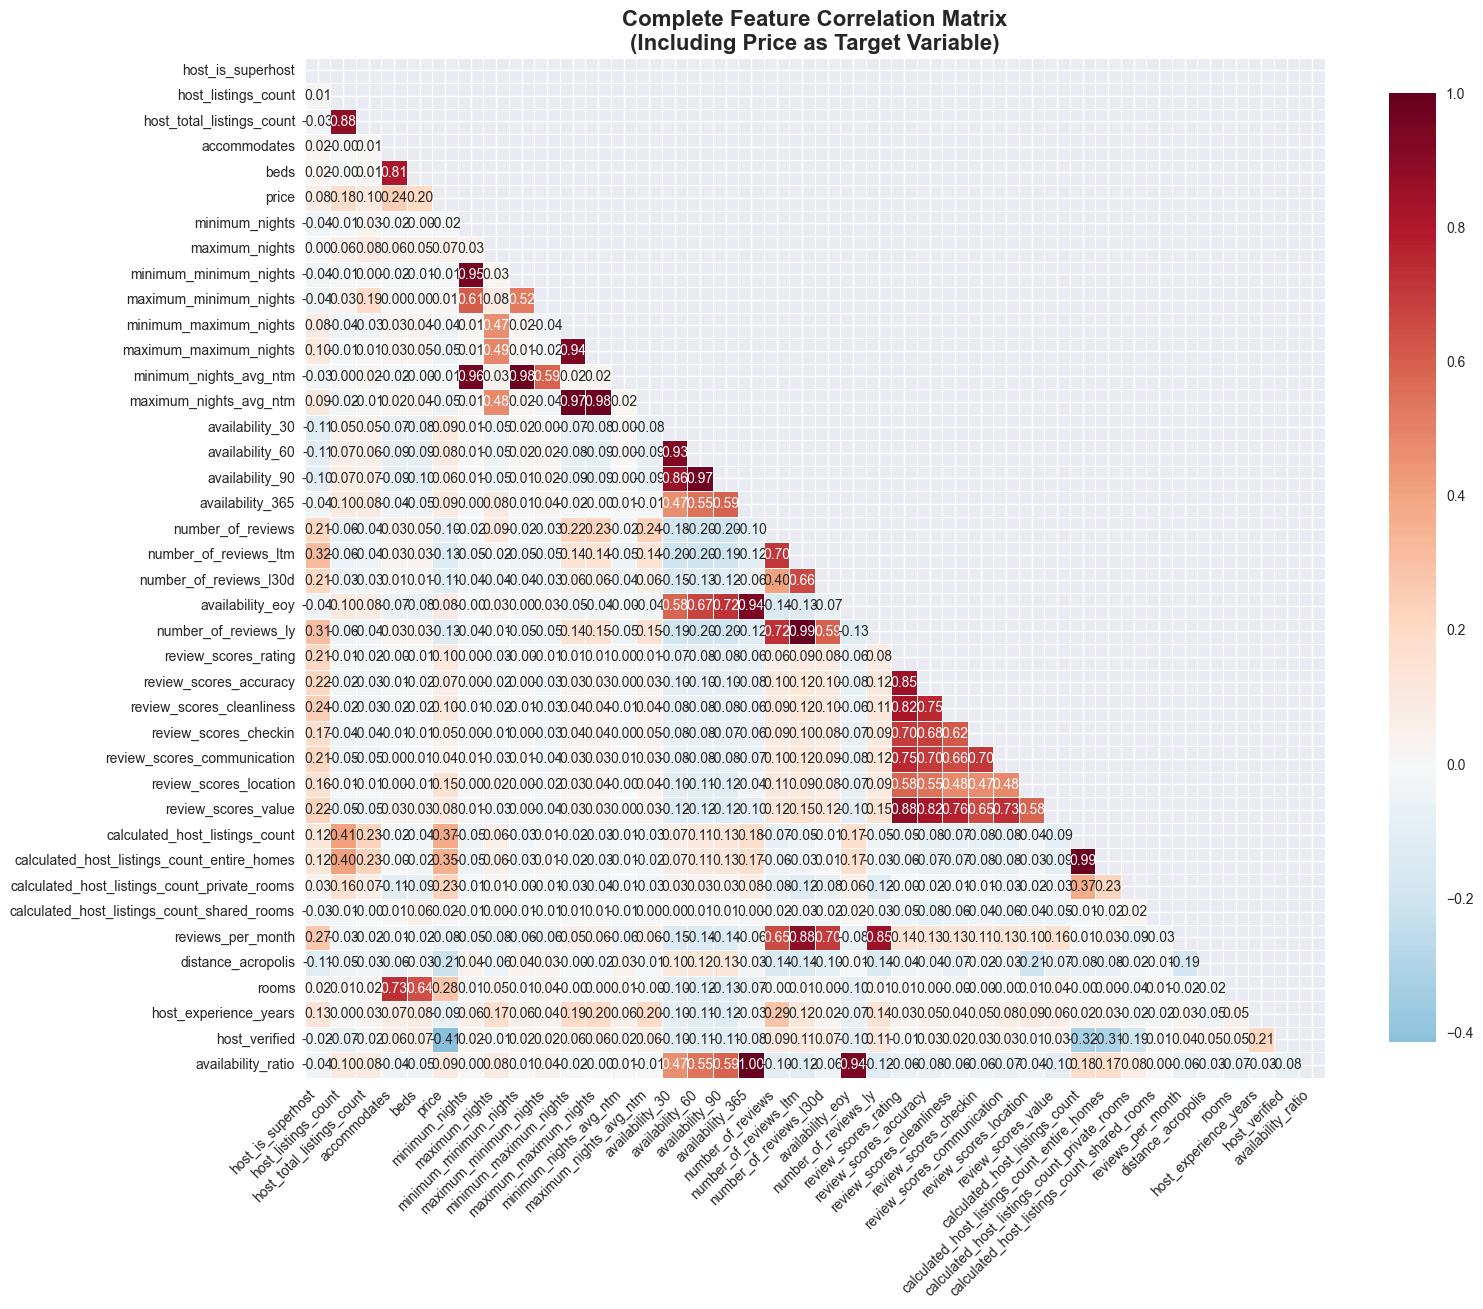

In [11]:
corr_features = df.columns
correlation_data = df[corr_features].select_dtypes(include=[np.number])
correlation_matrix = correlation_data.corr()

# Correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True, 
            fmt='.2f', 
            cbar_kws={'shrink': 0.8}, 
            linewidths=0.5)
plt.title('Complete Feature Correlation Matrix\n(Including Price as Target Variable)', 
          fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Make baseline RF model with all features for initial feature selection

In [12]:
df_baseline = df.copy()

df_baseline['property_type'] = df_baseline['property_type'].fillna('Unknown')
df_baseline = pd.get_dummies(df_baseline, columns=['property_type'], prefix='property_type', drop_first=True)

df_baseline.dropna(inplace=True)

Xt = df_baseline.drop('price', axis=1)  
yt = df_baseline['price']   

all_features = list(Xt.columns)            

print(f"X shape: {Xt.shape}")
print(f"y shape: {yt.shape}")
print(f"Features: {list(Xt.columns)}")

X shape: (10910, 45)
y shape: (10910,)
Features: ['host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'accommodates', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'distance_acropolis', 'rooms', 'host_experience_years', 'host_verified', 'availability_

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)
start_time = time.time()
rf_model_baseline = RandomForestRegressor(
    n_estimators=100, #100 before
    max_depth=8, #15
    min_samples_split=10, #5
    min_samples_leaf=5,#2
    max_features=0.7,
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

rf_model_baseline.fit(X_train, y_train)

# Make predictions
rf_pred_baseline = rf_model_baseline.predict(X_test)

# Calculate metrics
rf_r2_baseline = r2_score(y_test, rf_pred_baseline)
rf_mae_baseline = mean_absolute_error(y_test, rf_pred_baseline)
rf_rmse_baseline = np.sqrt(mean_squared_error(y_test, rf_pred_baseline))
end_time = time.time()
rf_time = end_time - start_time

print("Random Forest Results:")
print(f"R² Score: {rf_r2_baseline:.3f}")
print(f"MAE: €{rf_mae_baseline:.2f}")
print(f"RMSE: €{rf_rmse_baseline:.2f}")
print(f"Training Time: {rf_time:.2f} seconds")

# Test for overfitting
rf_pred_train_baseline = rf_model_baseline.predict(X_train)
rf_r2_train_baseline = r2_score(y_train, rf_pred_train_baseline)
rf_mae_train_baseline = mean_absolute_error(y_train, rf_pred_train_baseline)
rf_rmse_train_baseline = np.sqrt(mean_squared_error(y_train, rf_pred_train_baseline))

print("Random Forest Training Results(for comparison):")
print(f"R² Score: {rf_r2_train_baseline:.3f}")
print(f"MAE: €{rf_mae_train_baseline:.2f}")
print(f"RMSE: €{rf_rmse_train_baseline:.2f}")

# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Features:")
for _, row in rf_feature_importance.head(20).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

Random Forest Results:
R² Score: 0.496
MAE: €25.04
RMSE: €42.43
Training Time: 0.77 seconds
Random Forest Training Results(for comparison):
R² Score: 0.653
MAE: €21.93
RMSE: €35.73

Top Features:
  rooms: 0.363
  distance_acropolis: 0.155
  accommodates: 0.092
  review_scores_location: 0.055
  reviews_per_month: 0.037
  beds: 0.027
  review_scores_rating: 0.024
  review_scores_cleanliness: 0.023
  host_experience_years: 0.021
  number_of_reviews_ltm: 0.021
  maximum_nights: 0.012
  number_of_reviews: 0.012
  availability_90: 0.011
  availability_eoy: 0.011
  calculated_host_listings_count_entire_homes: 0.011
  review_scores_accuracy: 0.009
  minimum_nights_avg_ntm: 0.009
  calculated_host_listings_count: 0.008
  availability_30: 0.008
  number_of_reviews_ly: 0.007


In [ ]:
rf_feature_importance.head(10)

,feature,importance
35,rooms,0.363086
34,distance_acropolis,0.155304
3,accommodates,0.092351
27,review_scores_location,0.054744
33,reviews_per_month,0.037424
4,beds,0.026789
22,review_scores_rating,0.024330
24,review_scores_cleanliness,0.022563
36,host_experience_years,0.021323
18,number_of_reviews_ltm,0.020971


### Grid Search for better feature selection

In [ ]:
# Create pipeline with feature selection and Random Forest
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define parameter grid for both feature selection and RF
param_grid = {
    'feature_selection__k': [5, 10, 15, 20, 25, 30],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit the pipeline
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)

# Results
print(f"Best R² Score: {grid_search.best_score_:.3f}")
print(f"Best Parameters: {grid_search.best_params_}")

# Test on holdout set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print(f"Test R² Score: {test_r2:.3f}")

# Get selected features
selected_features = Xt.columns[best_model.named_steps['feature_selection'].get_support()]
print(f"Selected {len(selected_features)} features: {list(selected_features)}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best R² Score: 0.537
Best Parameters: {'feature_selection__k': 30, 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Test R² Score: 0.513
Selected 30 features: ['host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'accommodates', 'beds', 'maximum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'number_of_reviews_ly', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'distance_acropolis', 'rooms', 'host_experience_years', 'host_verified', 'property_type_Entire home', 'property_type_Room in hotel']


### Train baseline XGBoost model for feature selection

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)

# Scale only numeric features 
scaler_xgb = StandardScaler()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()


X_train_xgb = scaler_xgb.fit_transform(X_train)
X_test_xgb = scaler_xgb.transform(X_test)


# Train XGBoost 
start_time = time.time()
xgb_model = xgb.XGBRegressor(
    n_estimators=300, #300
    learning_rate=0.05, #0,05
    max_depth=3, #3
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_xgb, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test_xgb)

# Calculate metrics
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
end_time = time.time()
xgb_time = end_time - start_time

print("XGBoost Results:")
print(f"R² Score: {xgb_r2:.3f}")
print(f"MAE: €{xgb_mae:.2f}")
print(f"RMSE: €{xgb_rmse:.2f}")
print(f"Training Time: {xgb_time:.2f} seconds")

#Test for overfitting
xgb_pred_train = xgb_model.predict(X_train_xgb)
xgb_r2_train = r2_score(y_train, xgb_pred_train)
xgb_mae_train = mean_absolute_error(y_train, xgb_pred_train)
xgb_rmse_train = np.sqrt(mean_squared_error(y_train, xgb_pred_train))

print("XGBoost Training Results(for comparison):")
print(f"R² Score: {xgb_r2_train:.3f}")
print(f"MAE: €{xgb_mae_train:.2f}")
print(f"RMSE: €{xgb_rmse_train:.2f}")

# Feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Features:")
for _, row in xgb_feature_importance.head(20).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")



XGBoost Results:
R² Score: 0.532
MAE: €23.65
RMSE: €40.92
Training Time: 0.28 seconds
XGBoost Training Results(for comparison):
R² Score: 0.654
MAE: €21.72
RMSE: €35.69

Top Features:
  rooms: 0.128
  distance_acropolis: 0.065
  review_scores_location: 0.064
  accommodates: 0.050
  beds: 0.049
  review_scores_cleanliness: 0.038
  maximum_minimum_nights: 0.037
  number_of_reviews_ltm: 0.030
  calculated_host_listings_count: 0.028
  review_scores_rating: 0.027
  number_of_reviews_l30d: 0.027
  minimum_nights: 0.027
  maximum_maximum_nights: 0.023
  host_verified: 0.022
  maximum_nights: 0.022
  minimum_nights_avg_ntm: 0.021
  reviews_per_month: 0.021
  property_type_Room in hotel: 0.020
  host_is_superhost: 0.019
  property_type_Private room in rental unit: 0.019


In [22]:
xgb_feature_importance.head(10)

,feature,importance
35,rooms,0.128126
34,distance_acropolis,0.065338
27,review_scores_location,0.063534
3,accommodates,0.049750
4,beds,0.049077
24,review_scores_cleanliness,0.037660
8,maximum_minimum_nights,0.037188
18,number_of_reviews_ltm,0.029502
29,calculated_host_listings_count,0.028179
22,review_scores_rating,0.027433


### Gridsearch for XGBoost

In [27]:
# Create pipeline with feature selection and XGBoost
pipeline_xgb = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('xgb', xgb.XGBRegressor(random_state=42))
])

# Define parameter grid for both feature selection and XGBoost
param_grid_xgb = {
    'feature_selection__k': [8, 9, 10, 11, 12],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__subsample': [0.8],
    'xgb__colsample_bytree': [0.8],
    'xgb__min_child_weight': [3, 5]
}

# Grid search with cross-validation for XGBoost
grid_search_xgb = GridSearchCV(
    pipeline_xgb, 
    param_grid_xgb, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit the XGBoost pipeline
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)
grid_search_xgb.fit(X_train, y_train)

# Results for XGBoost
print(f"Best R² Score (XGBoost): {grid_search_xgb.best_score_:.3f}")
print(f"Best Parameters (XGBoost): {grid_search_xgb.best_params_}")

# Test XGBoost on holdout set
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)
test_r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"Test R² Score (XGBoost): {test_r2_xgb:.3f}")

# Get selected features for XGBoost
selected_features_xgb = Xt.columns[best_model_xgb.named_steps['feature_selection'].get_support()]
print(f"Selected {len(selected_features_xgb)} features (XGBoost): {list(selected_features_xgb)}")

# Feature importance for XGBoost (if you want to see it)
xgb_model = best_model_xgb.named_steps['xgb']
feature_importance_xgb = xgb_model.feature_importances_
selected_indices = best_model_xgb.named_steps['feature_selection'].get_support()
selected_importance = feature_importance_xgb

# Create feature importance DataFrame for selected features
feature_importance_df_xgb = pd.DataFrame({
    'Feature': selected_features_xgb,
    'Importance': selected_importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Feature Importance (XGBoost):")
print(feature_importance_df_xgb.head(10))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best R² Score (XGBoost): 0.515
Best Parameters (XGBoost): {'feature_selection__k': 12, 'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Test R² Score (XGBoost): 0.509
Selected 12 features (XGBoost): ['host_is_superhost', 'accommodates', 'beds', 'maximum_nights', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'distance_acropolis', 'rooms', 'property_type_Entire home']

Top 10 Feature Importance (XGBoost):
                      Feature  Importance
10                      rooms    0.296262
1                accommodates    0.126600
9          distance_acropolis    0.089581
2                        beds    0.070353
6      review_scores_location    0.068171
11  property_type_Entire home    0.066950
0           host_is_superhost    0.054590
5   revie

### Recursive Feature Elimination

In [ ]:
# Set number of features to select
k_features = 10  

# Fit RFE with Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=k_features, step=1, verbose=1)
rfe.fit(X_train, y_train)

# Get selected features from RFE
selected_features_rf = X_train.columns[rfe.support_]
print("Selected features (RF RFE):", list(selected_features_rf))

# Train and evaluate model on selected features
final_rf = RandomForestRegressor(n_estimators=100, random_state=42)
final_rf.fit(X_train[selected_features_rf], y_train)
y_pred_rf = final_rf.predict(X_test[selected_features_rf])
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R² Score (RF RFE): {r2_rf:.3f}")

Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 fe

In [35]:
k_features = 10 

scaler_xgb = StandardScaler()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()


X_train_xgb = scaler_xgb.fit_transform(X_train)
X_test_xgb = scaler_xgb.transform(X_test)


# Train XGBoost 
start_time = time.time()
xgb_model = xgb.XGBRegressor(
    n_estimators=300, #300
    learning_rate=0.05, #0,05
    max_depth=3, #3
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1
)

rfex =RFE(estimator=xgb_model, n_features_to_select=k_features, step=1, verbose=1)
rfex.fit(X_train_xgb, y_train)

selected_features_xgb = X_train.columns[rfex.support_]
print("Selected features (XGB RFE):", list(selected_features_xgb))

final_xgb = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=0.1,)
final_xgb.fit(X_train[selected_features_xgb], y_train)
y_pred_xgb = final_xgb.predict(X_test[selected_features_xgb])
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"R² Score (XGB RFE): {r2_xgb:.3f}")

Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 fe

### Keep most relevant features

In [17]:
numeric_features = [
    'rooms','accommodates',
    'calculated_host_listings_count',
    'distance_acropolis', 'host_experience_years',
     'host_verified',  'availability_ratio',
    'review_scores_rating','number_of_reviews'
]

model_df = df[numeric_features + ['property_type', 'price']].copy()

model_df['property_type'] = model_df['property_type'].fillna('Unknown')
model_df = pd.get_dummies(model_df, columns=['property_type'], prefix='property_type', drop_first=True)

model_df = model_df.dropna()

X = model_df.drop('price', axis=1)  
y = model_df['price']   

all_features = list(X.columns)            

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Features: {list(X.columns)}")

X shape: (13160, 15)
y shape: (13160,)
Features: ['rooms', 'accommodates', 'calculated_host_listings_count', 'distance_acropolis', 'host_experience_years', 'host_verified', 'availability_ratio', 'review_scores_rating', 'number_of_reviews', 'property_type_Entire home', 'property_type_Entire loft', 'property_type_Entire rental unit', 'property_type_Private room in hotel', 'property_type_Private room in rental unit', 'property_type_Room in hotel']


## Model Training

### Linear Regression

Linear Regression Results:
R² Score: 0.402
MAE: €42.06
RMSE: €66.83
Training Time: 0.02 seconds
Linear Regression Training Results(for comparison):
R² Score: 0.383
MAE: €42.85
RMSE: €69.64

Top 5 Most Important Features:
  host_verified: 0.213
  calculated_host_listings_count: 0.179
  rooms: 0.152
  distance_acropolis: 0.113
  accommodates: 0.068


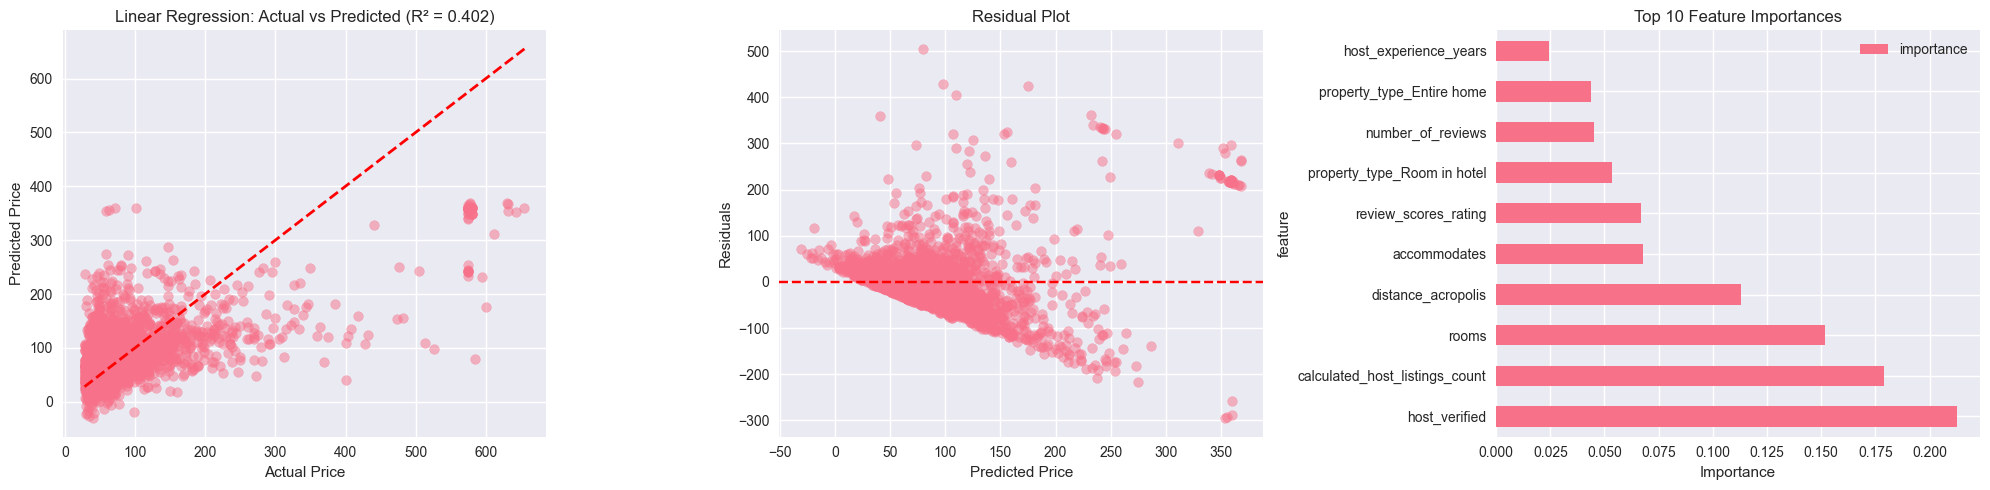

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for Linear Regression
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

# Train Linear Regression
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)

# Calculate metrics
lr_r2 = r2_score(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
end_time = time.time()
lr_time = end_time - start_time

print("Linear Regression Results:")
print(f"R² Score: {lr_r2:.3f}")
print(f"MAE: €{lr_mae:.2f}")
print(f"RMSE: €{lr_rmse:.2f}")
print(f"Training Time: {lr_time:.2f} seconds")

# Test for overfitting
lr_pred_train = lr_model.predict(X_train_scaled)
lr_r2_train = r2_score(y_train, lr_pred_train)
lr_mae_train = mean_absolute_error(y_train, lr_pred_train)
lr_rmse_train = np.sqrt(mean_squared_error(y_train, lr_pred_train))

print("Linear Regression Training Results(for comparison):")
print(f"R² Score: {lr_r2_train:.3f}")
print(f"MAE: €{lr_mae_train:.2f}")
print(f"RMSE: €{lr_rmse_train:.2f}")



# Feature importance 
lr_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': np.abs(lr_model.coef_)
}).sort_values('importance', ascending=False)
lr_feature_importance['importance'] = lr_feature_importance['importance'] / lr_feature_importance['importance'].sum()

print("\nTop 5 Most Important Features:")
for _, row in lr_feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Actual vs Predicted
axes[0].scatter(y_test, lr_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'Linear Regression: Actual vs Predicted (R² = {lr_r2:.3f})')

# Residuals
residuals = y_test - lr_pred
axes[1].scatter(lr_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Feature importance
lr_feature_importance.head(10).plot(x='feature', y='importance', kind='barh', ax=axes[2])
axes[2].set_title('Top 10 Feature Importances')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

### Random Forest

Random Forest Results:
R² Score: 0.682
MAE: €29.13
RMSE: €48.70
Training Time: 0.22 seconds
Random Forest Training Results(for comparison):
R² Score: 0.705
MAE: €28.44
RMSE: €48.17

Top 5 Most Important Features:
  calculated_host_listings_count: 0.477
  rooms: 0.143
  distance_acropolis: 0.093
  host_verified: 0.066
  accommodates: 0.058


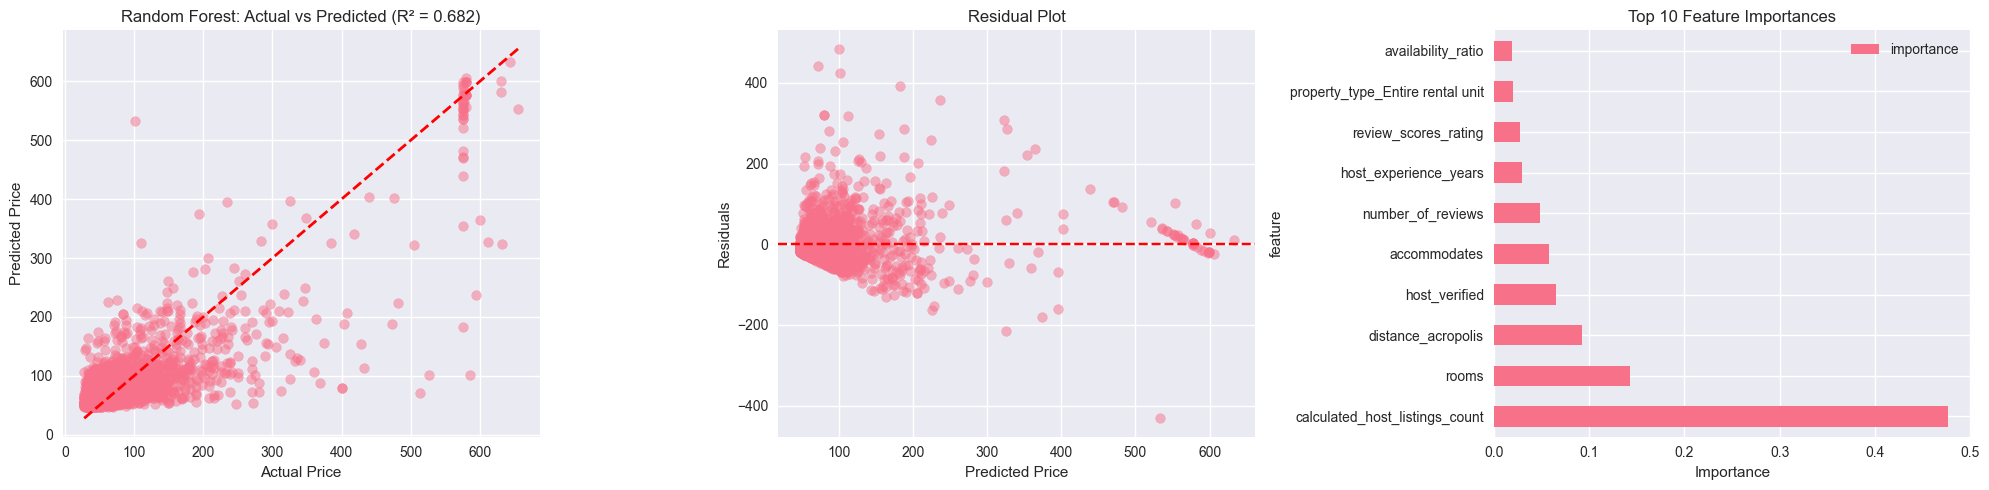

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train Random Forest
start_time = time.time()
rf_model = RandomForestRegressor(
    n_estimators=50, #50
    max_depth=8, #8
    min_samples_split=10, #10
    min_samples_leaf=5,#5
    max_features=0.7,
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Calculate metrics
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
end_time = time.time()
rf_time = end_time - start_time

print("Random Forest Results:")
print(f"R² Score: {rf_r2:.3f}")
print(f"MAE: €{rf_mae:.2f}")
print(f"RMSE: €{rf_rmse:.2f}")
print(f"Training Time: {rf_time:.2f} seconds")

# Test for overfitting
rf_pred_train = rf_model.predict(X_train)
rf_r2_train = r2_score(y_train, rf_pred_train)
rf_mae_train = mean_absolute_error(y_train, rf_pred_train)
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_pred_train))

print("Random Forest Training Results(for comparison):")
print(f"R² Score: {rf_r2_train:.3f}")
print(f"MAE: €{rf_mae_train:.2f}")
print(f"RMSE: €{rf_rmse_train:.2f}")

# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
for _, row in rf_feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Actual vs Predicted
axes[0].scatter(y_test, rf_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'Random Forest: Actual vs Predicted (R² = {rf_r2:.3f})')

# Residuals
residuals = y_test - rf_pred
axes[1].scatter(rf_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Feature importance
rf_feature_importance.head(10).plot(x='feature', y='importance', kind='barh', ax=axes[2])
axes[2].set_title('Top 10 Feature Importances')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

### Gradient Boosting

Gradient Boosting Results:
R² Score: 0.721
MAE: €27.52
RMSE: €45.62
Training Time: 2.46 seconds
Gradient Boosting Training Results(for comparison):
R² Score: 0.748
MAE: €26.85
RMSE: €44.51

Top 5 Most Important Features:
  calculated_host_listings_count: 0.437
  rooms: 0.152
  distance_acropolis: 0.106
  host_experience_years: 0.070
  accommodates: 0.051


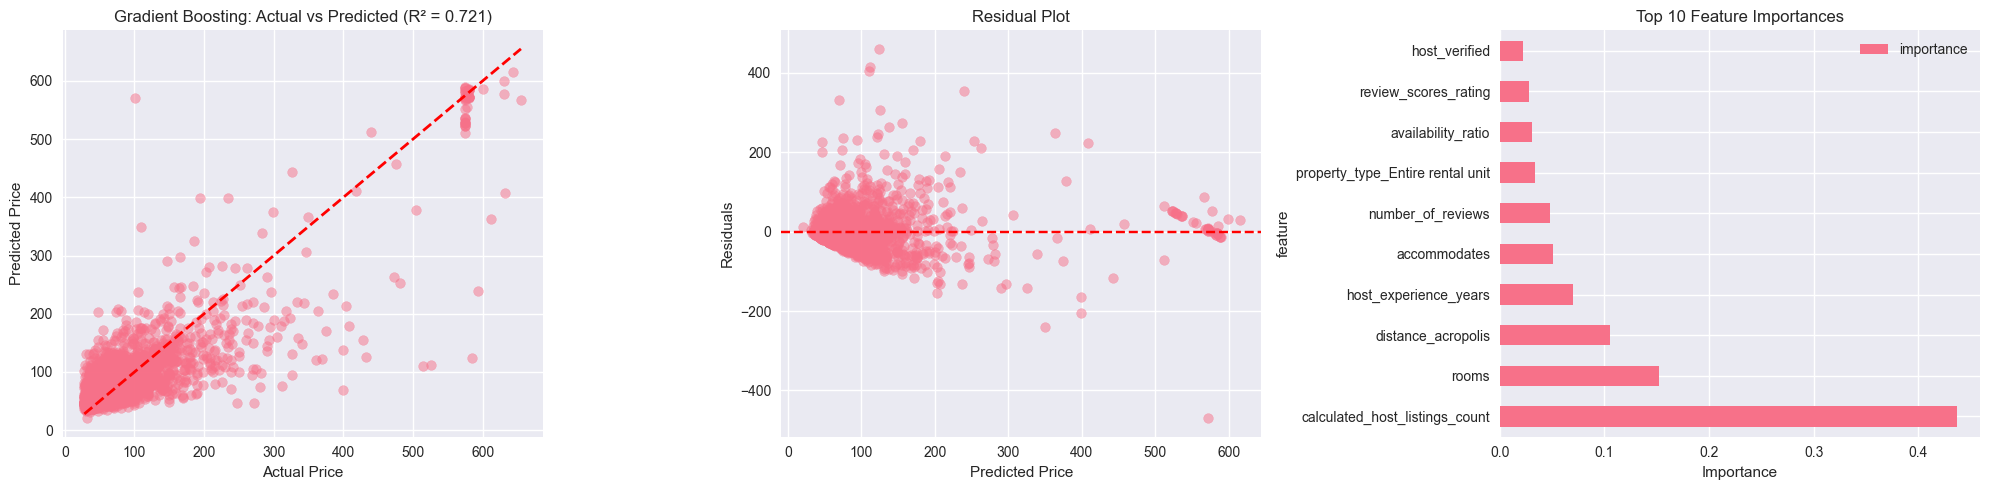

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

# Train Gradient Boosting
start_time = time.time()
gb_model = GradientBoostingRegressor(
    n_estimators=200,          
    learning_rate=0.05,        
    max_depth=4,               
    subsample=0.8,             # use 80% of data per tree
    validation_fraction=0.2,   # use 20% for internal validation
    n_iter_no_change=20,       # early stopping
    tol=1e-4,                  
    random_state=42
)
gb_model.fit(X_train, y_train)

# Make predictions
gb_pred = gb_model.predict(X_test)

# Calculate metrics
gb_r2 = r2_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
end_time = time.time()
gb_time = end_time - start_time

print("Gradient Boosting Results:")
print(f"R² Score: {gb_r2:.3f}")
print(f"MAE: €{gb_mae:.2f}")
print(f"RMSE: €{gb_rmse:.2f}")
print(f"Training Time: {gb_time:.2f} seconds")

# Test for overfitting
gb_pred_train = gb_model.predict(X_train)
gb_r2_train = r2_score(y_train, gb_pred_train)
gb_mae_train = mean_absolute_error(y_train, gb_pred_train)
gb_rmse_train = np.sqrt(mean_squared_error(y_train, gb_pred_train))

print("Gradient Boosting Training Results(for comparison):")
print(f"R² Score: {gb_r2_train:.3f}")
print(f"MAE: €{gb_mae_train:.2f}")
print(f"RMSE: €{gb_rmse_train:.2f}")

# Feature importance
gb_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
for _, row in gb_feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Actual vs Predicted
axes[0].scatter(y_test, gb_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'Gradient Boosting: Actual vs Predicted (R² = {gb_r2:.3f})')

# Residuals
residuals = y_test - gb_pred
axes[1].scatter(gb_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Feature importance
gb_feature_importance.head(10).plot(x='feature', y='importance', kind='barh', ax=axes[2])
axes[2].set_title('Top 10 Feature Importances')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

### XGBoost

Best iteration: 299
XGBoost Results:
R² Score: 0.711
MAE: €28.10
RMSE: €46.44
Training Time: 0.30 seconds
XGBoost Training Results(for comparison):
R² Score: 0.711
MAE: €27.69
RMSE: €46.95

Top 5 Most Important Features:
  calculated_host_listings_count: 0.234
  property_type_Entire rental unit: 0.144
  host_verified: 0.137
  rooms: 0.119
  number_of_reviews: 0.062


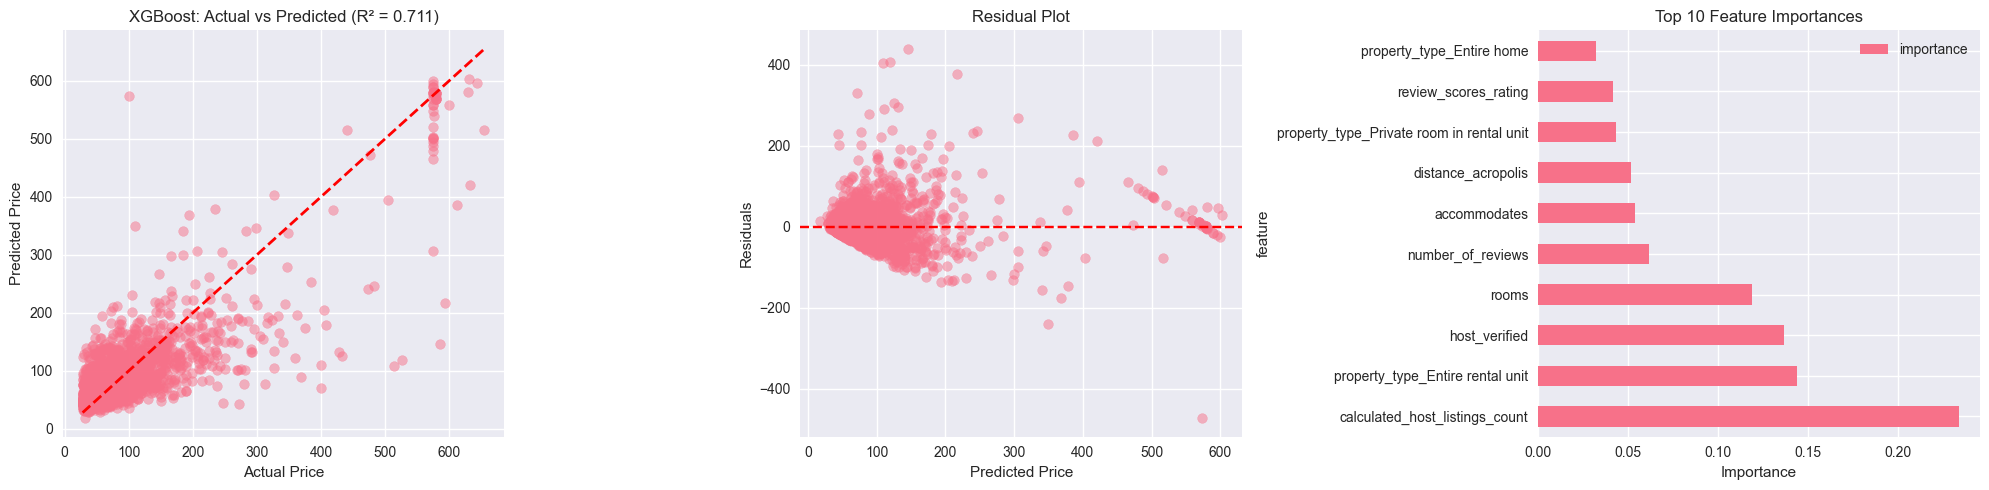

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Scale only numeric features 
scaler_xgb = StandardScaler()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()
X_val_xgb = X_val.copy()

X_train_xgb[numeric_features] = scaler_xgb.fit_transform(X_train[numeric_features])
X_test_xgb[numeric_features] = scaler_xgb.transform(X_test[numeric_features])
X_val_xgb[numeric_features] = scaler_xgb.transform(X_val[numeric_features])

# Train XGBoost 
start_time = time.time()
xgb_model = xgb.XGBRegressor(
    n_estimators=300, #300
    learning_rate=0.05, #0,05
    max_depth=3, #3
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    early_stopping_rounds=20, #early stopping
    eval_metric='rmse',
    n_jobs=-1
)
#xgb_model.fit(X_train_xgb, y_train)
xgb_model.fit(
    X_train_xgb, y_train,
    eval_set=[(X_val_xgb, y_val)], #use eval set for early stopping
    verbose=False
)
print(f"Best iteration: {xgb_model.best_iteration}")
# Make predictions
xgb_pred = xgb_model.predict(X_test_xgb,iteration_range=(0, xgb_model.best_iteration + 1))

# Calculate metrics
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
end_time = time.time()
xgb_time = end_time - start_time

print("XGBoost Results:")
print(f"R² Score: {xgb_r2:.3f}")
print(f"MAE: €{xgb_mae:.2f}")
print(f"RMSE: €{xgb_rmse:.2f}")
print(f"Training Time: {xgb_time:.2f} seconds")

#Test for overfitting
xgb_pred_train = xgb_model.predict(X_train_xgb)
xgb_r2_train = r2_score(y_train, xgb_pred_train)
xgb_mae_train = mean_absolute_error(y_train, xgb_pred_train)
xgb_rmse_train = np.sqrt(mean_squared_error(y_train, xgb_pred_train))

print("XGBoost Training Results(for comparison):")
print(f"R² Score: {xgb_r2_train:.3f}")
print(f"MAE: €{xgb_mae_train:.2f}")
print(f"RMSE: €{xgb_rmse_train:.2f}")

# Feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
for _, row in xgb_feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Actual vs Predicted
axes[0].scatter(y_test, xgb_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'XGBoost: Actual vs Predicted (R² = {xgb_r2:.3f})')

# Residuals
residuals = y_test - xgb_pred
axes[1].scatter(xgb_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Feature importance
xgb_feature_importance.head(10).plot(x='feature', y='importance', kind='barh', ax=axes[2])
axes[2].set_title('Top 10 Feature Importances')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

### LightGBM

LightGBM Results:
R² Score: 0.701
MAE: €28.25
RMSE: €47.21
Training Time: 1.47 seconds
LightGBM Training Results(for comparison):
R² Score: 0.732
MAE: €26.49
RMSE: €45.22

Top 5 Most Important Features:
  host_experience_years: 0.185
  distance_acropolis: 0.158
  calculated_host_listings_count: 0.147
  availability_ratio: 0.128
  number_of_reviews: 0.097


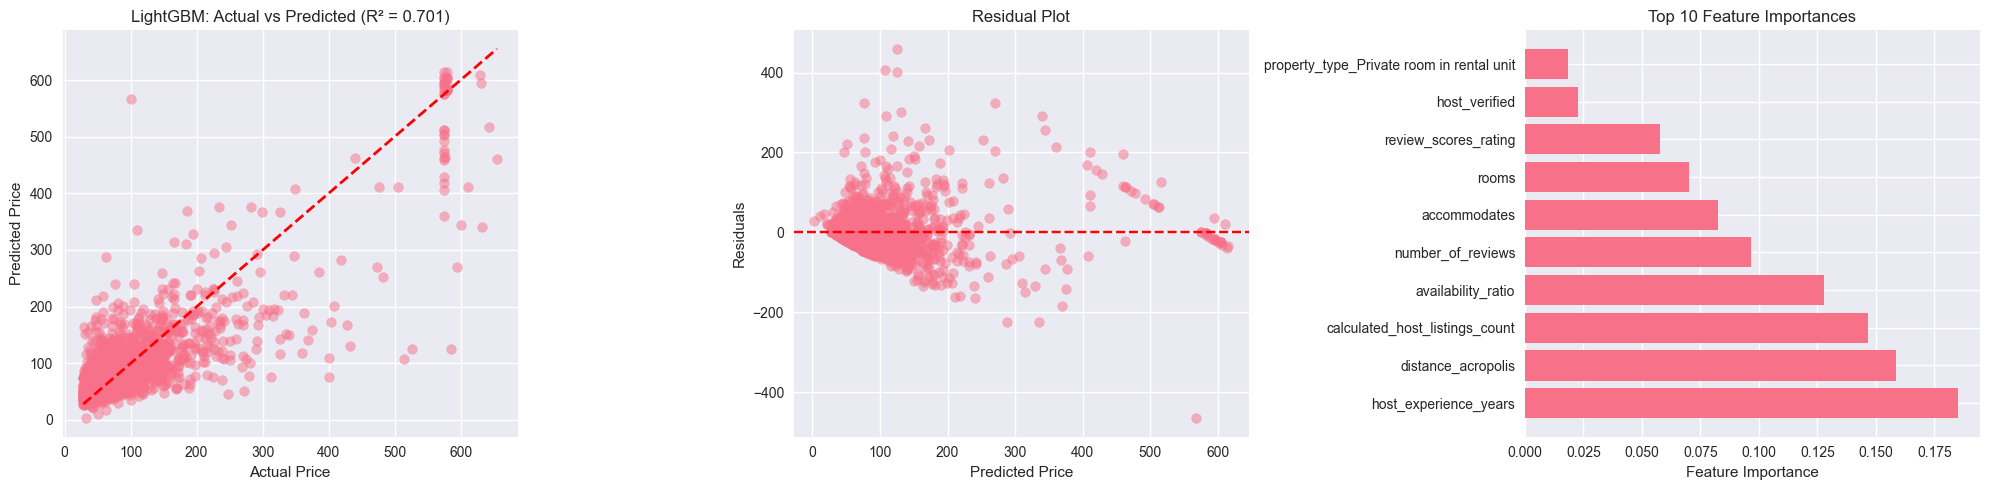

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Train LightGBM 
start_time = time.time()
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,        
    max_depth=4,                
    min_child_samples=20,      
    subsample=0.8,           
    colsample_bytree=0.8,     
    reg_alpha=0.1,       
    reg_lambda=0.1,          
    random_state=42,
    early_stopping_rounds=10, #early stopping
    eval_metric='mae',
    verbose=-1
)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)] # use eval set for early stopping
)
lgb_train_time = time.time() - start_time

# Make predictions
lgb_pred = lgb_model.predict(X_test)

# Calculate metrics
lgb_r2 = r2_score(y_test, lgb_pred)
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
end_time = time.time()
lgb_time = end_time - start_time

print("LightGBM Results:")
print(f"R² Score: {lgb_r2:.3f}")
print(f"MAE: €{lgb_mae:.2f}")
print(f"RMSE: €{lgb_rmse:.2f}")
print(f"Training Time: {lgb_time:.2f} seconds")

# Test for overfitting
lgb_pred_train = lgb_model.predict(X_train)
lgb_r2_train = r2_score(y_train, lgb_pred_train)
lgb_mae_train = mean_absolute_error(y_train, lgb_pred_train)
lgb_rmse_train = np.sqrt(mean_squared_error(y_train, lgb_pred_train))   

print("LightGBM Training Results(for comparison):")
print(f"R² Score: {lgb_r2_train:.3f}")
print(f"MAE: €{lgb_mae_train:.2f}")
print(f"RMSE: €{lgb_rmse_train:.2f}")

# Feature importance 
lgb_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

lgb_feature_importance['importance'] = lgb_feature_importance['importance'] / lgb_feature_importance['importance'].sum()

print("\nTop 5 Most Important Features:")
for _, row in lgb_feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Actual vs Predicted
axes[0].scatter(y_test, lgb_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'LightGBM: Actual vs Predicted (R² = {lgb_r2:.3f})')

# Residuals
residuals = y_test - lgb_pred
axes[1].scatter(lgb_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Feature Importance
top_features = lgb_feature_importance.head(10)
axes[2].barh(range(len(top_features)), top_features['importance'])
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels(top_features['feature'])
axes[2].set_xlabel('Feature Importance')
axes[2].set_title('Top 10 Feature Importances')

plt.tight_layout()
plt.show()

## Model Comparison

MODEL PERFORMANCE COMPARISON:
                   R² Score    MAE (€)   RMSE (€) Training Time (s)
Linear Regression  0.401715  42.058513  66.834094          0.022595
Random Forest      0.682272  29.132209   48.70477          0.224967
Gradient Boosting  0.721262  27.522921  45.618621          2.457011
XGBoost            0.711099  28.100423  46.442798          0.302069
LightGBM           0.701465  28.250925  47.210826          1.474264

Best Models: R²=Gradient Boosting, MAE=Gradient Boosting, RMSE=Gradient Boosting, Training Time=Linear Regression


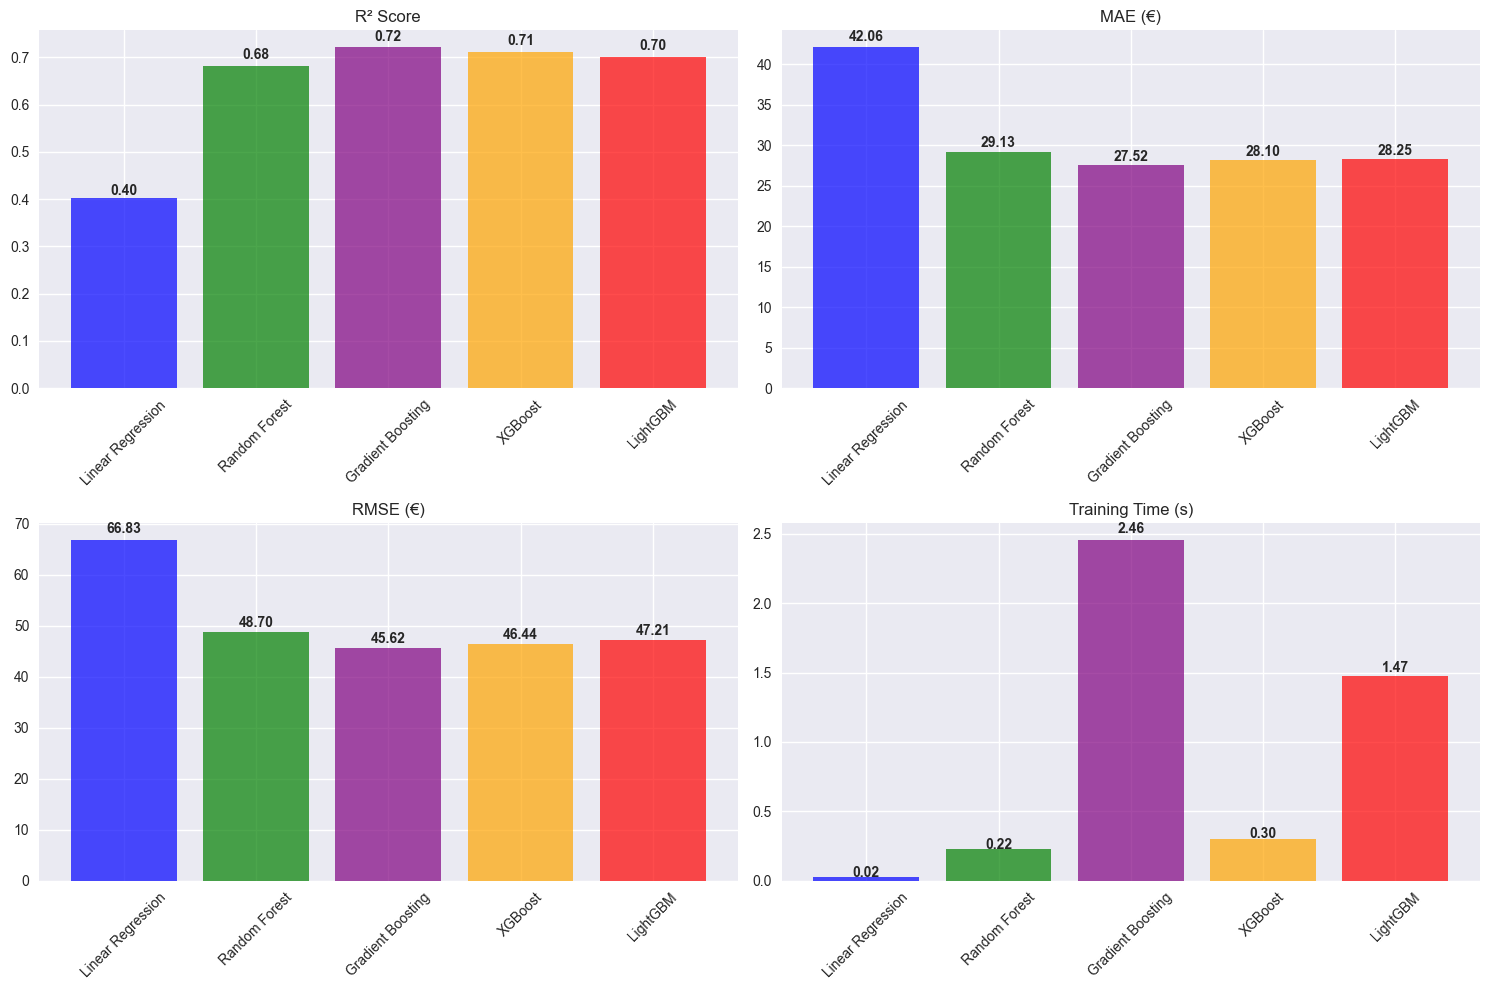

In [23]:
# Collect all results
models_results = {
    'Linear Regression': {'R2': lr_r2, 'MAE': lr_mae, 'RMSE': lr_rmse, 'Training Time': lr_time, 'predictions': lr_pred},
    'Random Forest': {'R2': rf_r2, 'MAE': rf_mae, 'RMSE': rf_rmse, 'Training Time': rf_time, 'predictions': rf_pred},
    'Gradient Boosting': {'R2': gb_r2, 'MAE': gb_mae, 'RMSE': gb_rmse, 'Training Time': gb_time, 'predictions': gb_pred},
    'XGBoost': {'R2': xgb_r2, 'MAE': xgb_mae, 'RMSE': xgb_rmse, 'Training Time': xgb_time, 'predictions': xgb_pred},
    'LightGBM': {'R2': lgb_r2, 'MAE': lgb_mae, 'RMSE': lgb_rmse, 'Training Time': lgb_time, 'predictions': lgb_pred}
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_results).T
comparison_df.columns = ['R² Score', 'MAE (€)', 'RMSE (€)', 'Training Time (s)', 'Predictions']

print("MODEL PERFORMANCE COMPARISON:")
print(comparison_df[['R² Score', 'MAE (€)', 'RMSE (€)', 'Training Time (s)']].round(3))

# Best models
best_models = {
    'R²': comparison_df['R² Score'].idxmax(),
    'MAE': comparison_df['MAE (€)'].idxmin(), 
    'RMSE': comparison_df['RMSE (€)'].idxmin(),
    'Training Time': comparison_df['Training Time (s)'].idxmin()
}
print(f"\nBest Models: R²={best_models['R²']}, MAE={best_models['MAE']}, RMSE={best_models['RMSE']}, Training Time={best_models['Training Time']}")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ['blue', 'green', 'purple', 'orange', 'red']

# Metrics bar charts
metrics = [('R² Score', 'R² Score'), ('MAE (€)', 'MAE (€)'), ('RMSE (€)', 'RMSE (€)')]
for i, (col, title) in enumerate(metrics):
    row, col_idx = (0, i) if i < 2 else (1, 0)
    axes[row, col_idx].bar(comparison_df.index, comparison_df[col], color=colors, alpha=0.7)
    axes[row, col_idx].set_title(title)
    axes[row, col_idx].tick_params(axis='x', rotation=45)
    for j, v in enumerate(comparison_df[col]):
        axes[row, col_idx].text(j, v + v*0.02, f'{v:.2f}', ha='center', fontweight='bold')

# Training time plot
axes[1,1].bar(comparison_df.index, comparison_df['Training Time (s)'], color=colors, alpha=0.7)
axes[1,1].set_title('Training Time (s)')
axes[1,1].tick_params(axis='x', rotation=45)
for j, v in enumerate(comparison_df['Training Time (s)']):
    axes[1,1].text(j, v + v*0.02, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Feature importance comparison

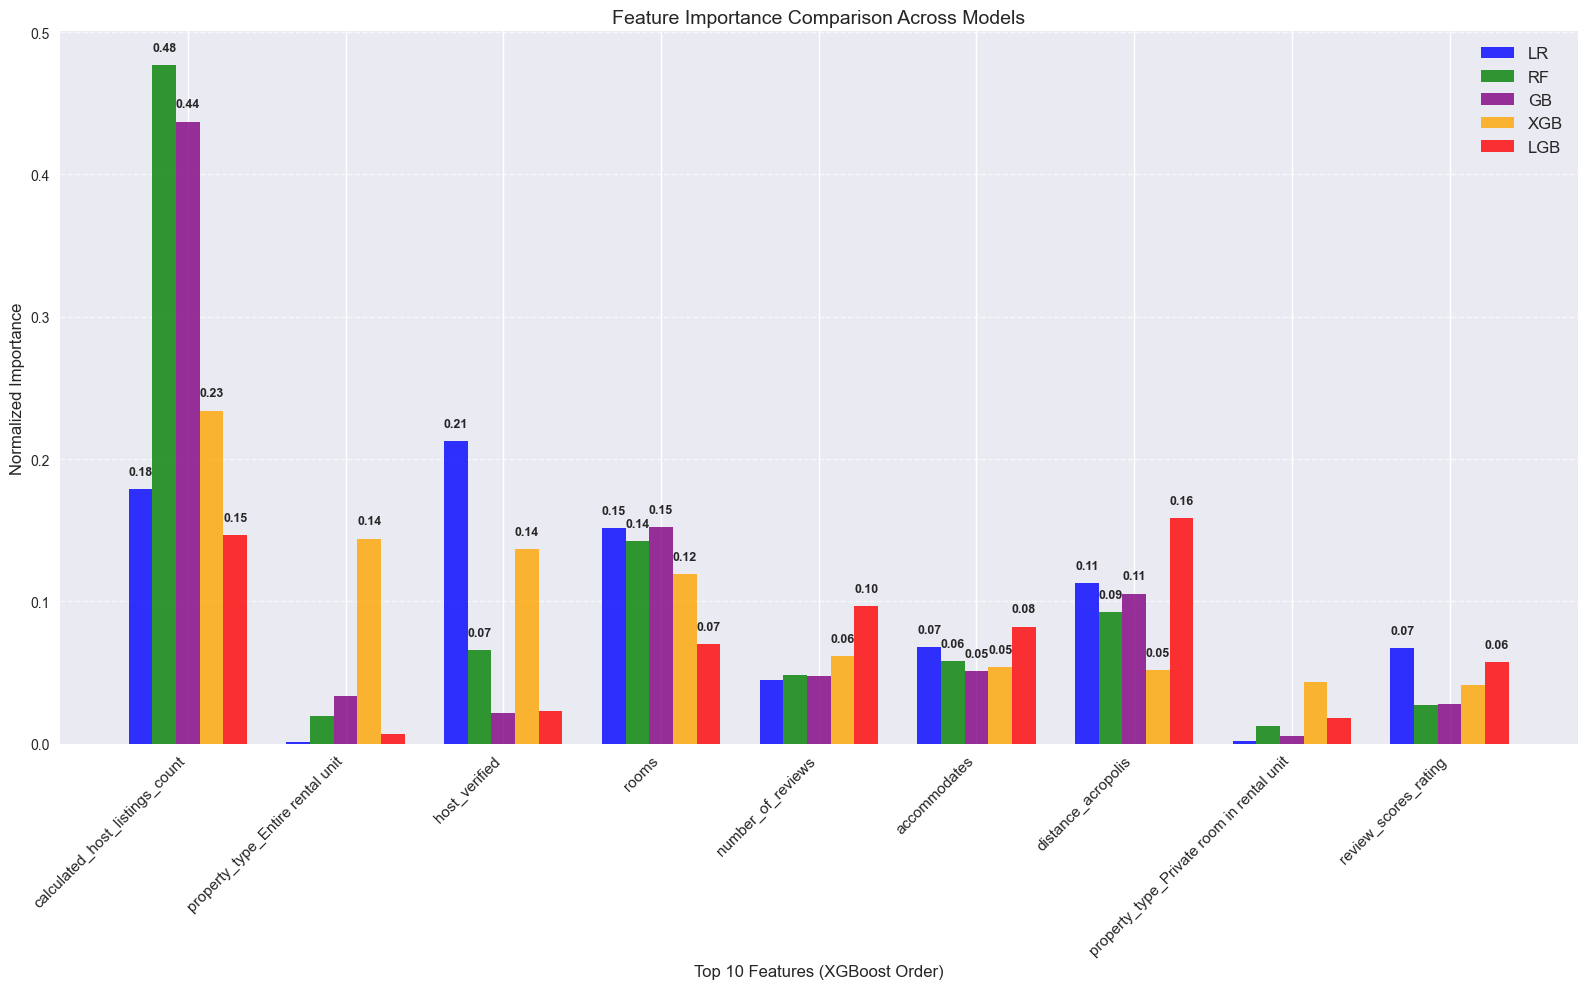

In [24]:
# Feature Importance Comparison
plt.figure(figsize=(16, 10))  

try:
    importances = []
    labels = ['LR', 'RF', 'GB', 'XGB', 'LGB']
    importance_vars = [lr_feature_importance, rf_feature_importance, gb_feature_importance, 
                      xgb_feature_importance, lgb_feature_importance]
    
    # Use XGBoost's feature order
    xgb_features = xgb_feature_importance.head(9)['feature'].tolist()
    
    # For each model, extract importance for XGBoost's top 10 features
    for imp_df in importance_vars:
        model_importances = []
        for feature in xgb_features:
            if feature in imp_df['feature'].values:
                feature_importance = imp_df[imp_df['feature'] == feature]['importance'].iloc[0]
                model_importances.append(feature_importance)
            else:
                model_importances.append(0)
        importances.append(model_importances)
    
    # Plot 
    x = np.arange(9)
    width = 0.15
    for i, (imp, label, color) in enumerate(zip(importances, labels, colors)):
        plt.bar(x + i*width - 2*width, imp, width, label=label, color=color, alpha=0.8)
    
    plt.xlabel('Top 10 Features (XGBoost Order)', fontsize=12)
    plt.ylabel('Normalized Importance', fontsize=12)
    plt.title('Feature Importance Comparison Across Models', fontsize=14)
    plt.xticks(x, xgb_features, rotation=45, ha='right', fontsize=11)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels 
    for i, model_imp in enumerate(importances):
        for j, v in enumerate(model_imp):
            if v >= 0.05:  # Only label bars with importance >= 5%
                plt.text(j + i*width - 2*width, v + 0.01, f'{v:.2f}', 
                        ha='center', fontweight='bold', fontsize=9)
    
except Exception as e:
    plt.text(0.5, 0.5, f'Feature importance comparison unavailable\n{str(e)}', 
            ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

### Overfitting report

In [25]:
# Model Comparison with Train/Test metrics for overfitting check
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
    'Train R²': [lr_r2_train, rf_r2_train, gb_r2_train, xgb_r2_train, lgb_r2_train],
    'Test R²': [lr_r2, rf_r2, gb_r2, xgb_r2, lgb_r2],
    'R² Gap': [lr_r2_train-lr_r2, rf_r2_train-rf_r2, gb_r2_train-gb_r2, xgb_r2_train-xgb_r2, lgb_r2_train-lgb_r2],
    'Test MAE': [lr_mae, rf_mae, gb_mae, xgb_mae, lgb_mae],
    'Test RMSE': [lr_rmse, rf_rmse, gb_rmse, xgb_rmse, lgb_rmse],
    'Time (s)': [lr_time, rf_time, gb_time, xgb_time, lgb_time]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("Model Performance Comparison (Overfitting Check):")
print(comparison_df.round(3))



Model Performance Comparison (Overfitting Check):
               Model  Train R²  Test R²  R² Gap  Test MAE  Test RMSE  Time (s)
2  Gradient Boosting     0.748    0.721   0.027    27.523     45.619     2.457
3            XGBoost     0.711    0.711  -0.000    28.100     46.443     0.302
4           LightGBM     0.732    0.701   0.030    28.251     47.211     1.474
1      Random Forest     0.705    0.682   0.023    29.132     48.705     0.225
0  Linear Regression     0.383    0.402  -0.019    42.059     66.834     0.023
